<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

## Test basic MWR runout behavior by simulating the collapse and runout of a 5 meter high pile of debris

#### This tutorial demonstrates how to set up MassWastingRunout (MWR) to model the runout of the collapse of a 5-meter high pile of debris.

In this example we will:
- select MWR parameter values and set up a raster model grid representation of the pile
- instantiate MWR and run the model
- view animations of the runout

#### Model overview
- MWR models the downslope progression of mass wasting processes such as debris flows or dry debris avalanches

- Mass-continuity is central to model conceptualization; at any node, the incoming flux (qsI_n) erosion (E_n) and aggradation A_n) determine outgoing flux (qsO_n) and ultimtely the runout extent and how the landscape evolves. 

<div>
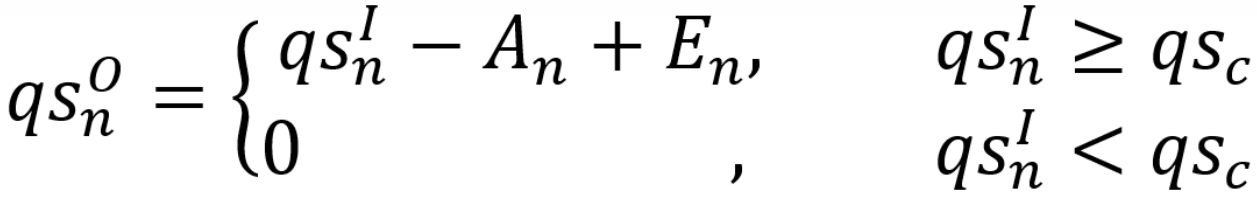
<div>    

- MWR uses a set of rules and algorithms to numercally represent the release of the mass wasting source material, erosion, deposition and the impact of vegetation/debris on the runout process as illustrated below:

<div>
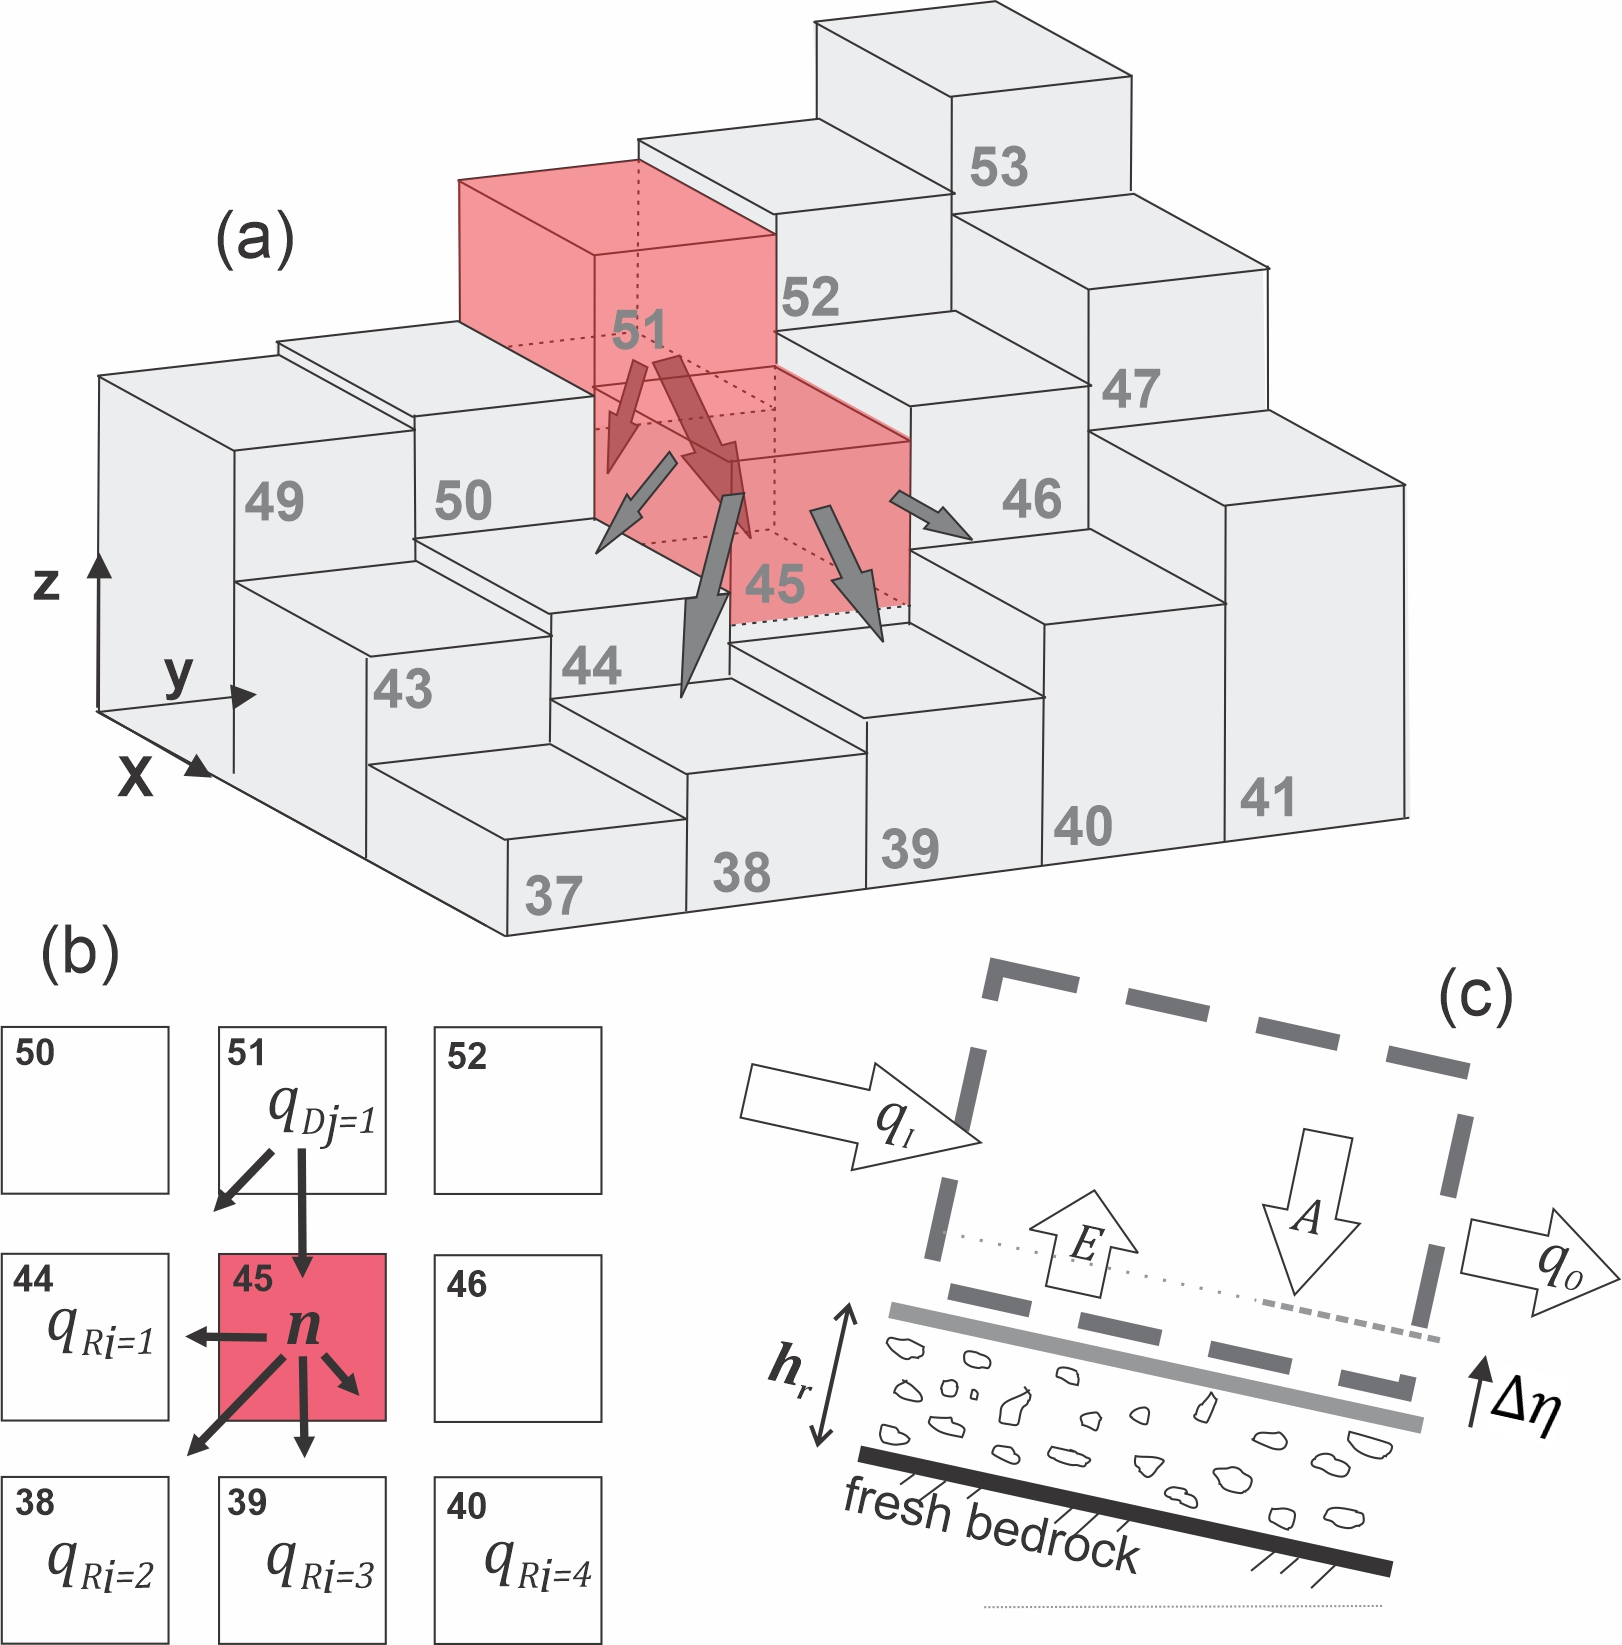
<div>    

<strong><em>(a)</em></strong> Release of the initial mass wasting source material nodes (represented by red cells) <strong><em>(b)</em></strong> How qsO_n is distributed downslope after incoming material qsI_n (here equal to qs_Dn1,n) has aggraded (A_n) or eroded (E_n). node n <strong><em>(c)</em></strong> Mass continuity determines the change in regolith/topographic surface. For a full description of the above parameters, see Keck et al. (2024) 

#### First, import python packages and Landlab components necessary to run the component

In [2]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np

from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FlowDirectorMFD
from landlab import imshowhs_grid, imshow_grid
from landlab.components.mass_wasting_runout import MassWastingRunout

#### Next, define the model domain, geometry of the pile and MassWastingRunout parameters Sc, qs_c and k

In [3]:
# model domain
r = 51 # rows in model domain
c = r # columns
dxdy = 5 # cell size
hs = 1 # soil thickness
Dp = 0.2 # maximum particle diameter in soil

# define the pile
ls_h = 5 # height of pile
w = 5 # radius of pile

# MassWastingRunout parameters
Sc = [0.03]  # critical slope
qsi = 0.01 # threshold flux
k = 0.02 # erosion coefficient

### create model grid and add necessary grid fields

In [6]:
mg = RasterModelGrid((r,c),dxdy)

dem = mg.add_field('topographic__elevation',
                    np.ones(r*c)*1,
                    at='node')

mg.at_node['node_id'] = np.hstack(mg.nodes)
# domain for plots
xmin = mg.node_x.min(); xmax = mg.node_x.max(); ymin = mg.node_y.min(); ymax = mg.node_y.max()
# set boundary conditions, add flow direction
mg.set_closed_boundaries_at_grid_edges(True, True, True, True) #close all boundaries
# flow directions
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()
# soil thickness
thickness = np.ones(mg.number_of_nodes)*hs
mg.add_field('soil__thickness',thickness, at = 'node')
# set particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Dp
# copy of initial topography
DEMi = mg.at_node['topographic__elevation'].copy()

### run flow director to add slope and receiving node fields

In [7]:
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'square_root_of_slope')
fd.run_one_step()

### create the pile

In [8]:
# find central point in domain
x = mg.node_x.max()/2
y = mg.node_y.max()/2

# find all nodes with radius of central point
dn = ((mg.node_x-x)**2+(mg.node_y-y)**2)**0.5
pile_nodes = np.hstack(mg.nodes)[dn<w*mg.dx]

# set those nodes as the landslide (they're all given the same mass__wasting_id number)
mg.at_node['mass__wasting_id'] = np.zeros(mg.number_of_nodes).astype(int)
mg.at_node['mass__wasting_id'][pile_nodes] = 1

# set thickness of landslide (in this case the pile)
mg.at_node['soil__thickness'][pile_nodes] = ls_h
mg.at_node['topographic__elevation'][pile_nodes] =   mg.at_node['topographic__elevation'][pile_nodes]+(ls_h-hs)

### take a look at the pile

Zmin1.0, Zmax5.0


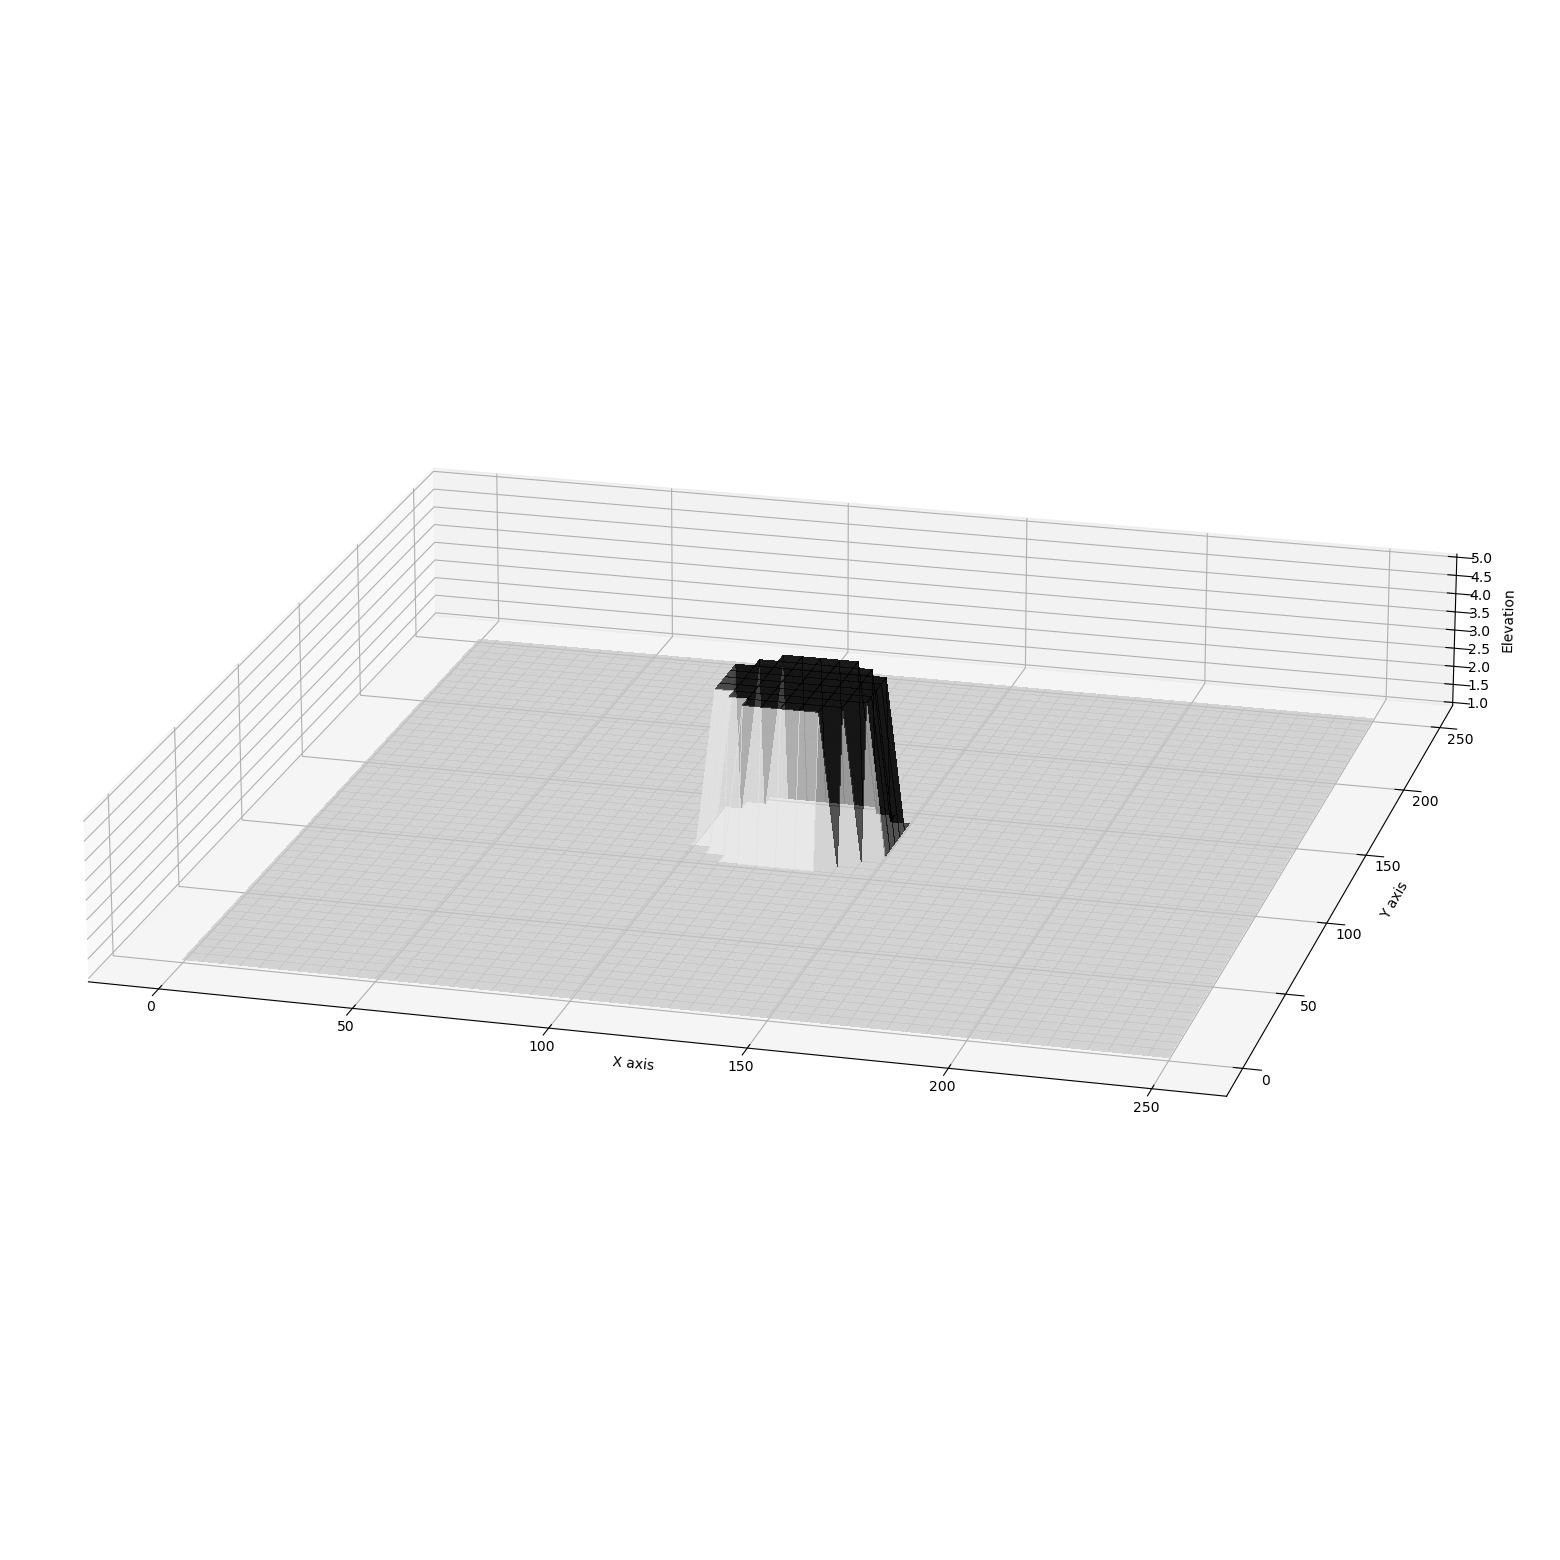

In [9]:
# borrow the plotting routine from the flow-director notebooks to make a 3d plot of our surface.
# import plotting tools
def surf_plot_ani(mg,
              surface='topographic__elevation',
              title='', zlim = None):

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print('Zmin{}, Zmax{}'.format(Z.min(), Z.max()))
    color = cm.gray_r((Z - Z.min())*2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                          alpha = 0.67)
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    ax.set_box_aspect([1, 1, 0.15])
    if zlim:
        ax.set_zlim(zlim)
    plt.show()
    return surf

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(projection='3d')
a = surf_plot_ani(mg)

### that's a nice looking pile...now set up an instance of MassWastingRuntout to model its collapse and runout 

In [10]:
MWRu = MassWastingRunout(mg, 
                         critical_slope = Sc,
                         threshold_flux = qsi,
                         erosion_coefficient = k,
                         effective_qsi = False, 
                         save = True, 
                         grain_shear = False, 
                         settle_deposit = True)

### run the instance of MassWastingRunout

In [11]:
start_time = time.time()
MWRu.run_one_step()

### view of the pile as it ranout

#### first in 3d view

Zmin1.0, Zmax5.0


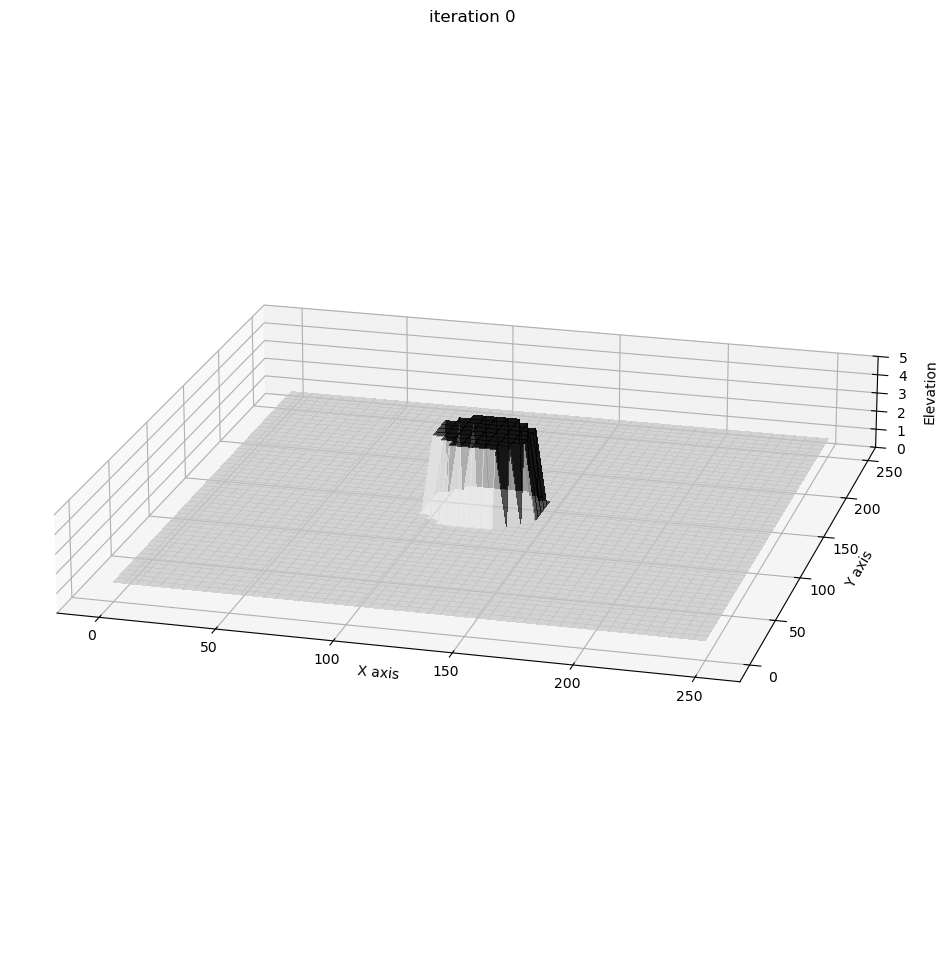

Zmin1.0, Zmax5.0


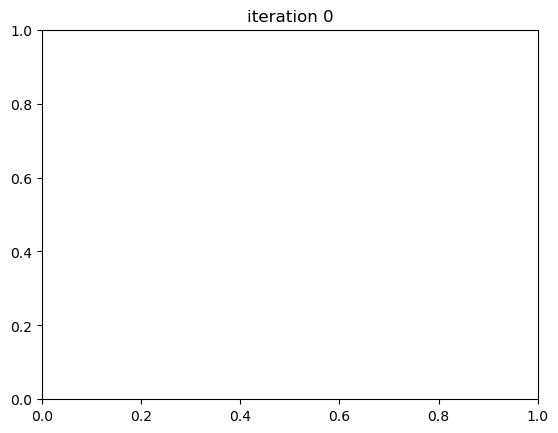

RuntimeError: The animation function must return a sequence of Artist objects.

In [19]:
# modified
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML

def update_plot(frame_number, MWRu, plot):
    mg.at_node['topographic__elevation'] = MWRu.saver.runout_evo_maps[0][frame_number]
    plot[0].remove()
    plot[0] = surf_plot_ani(mg ,'topographic__elevation','iteration '+str(frame_number),zlim = [0,5])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')

nmax=len(MWRu.saver.runout_evo_maps[0].keys())
mg.at_node['topographic__elevation'] = MWRu.saver.runout_evo_maps[0][0]
plot = [surf_plot_ani(mg ,'topographic__elevation','iteration '+str(0),zlim = [0,5])]
#animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWRu, plot), blit = True, repeat = True)
animate = animation.FuncAnimation(
    fig, update_plot, nmax, fargs=(MWRu, plot),b lit = True, repeat=True
)

#plt.show()
HTML(animate.to_jshtml())